In [22]:
import sqlite3
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from transformers import AutoTokenizer, BertForSequenceClassification, pipeline

torch.cuda.is_available()

True

In [2]:
conn = sqlite3.connect('../letters.db')
cursor = conn.cursor()

res = cursor.execute("""
    select * from letters 
    where gestora = 'Encore' and title like '%Comentário%'
""")

res.fetchone()

(142,
 'Encore',
 'Comentário Mensal – Dezembro 2024',
 '2025-01-29',
 'https://www.youtube.com/watch?v=iWPZ9qNKifg',
 '[Música] Olá pessoal meu nome é João luí Braga sou anista da encor e vim aqui um pouco atrasado para gravar ainda é janeiro né Hoje é dia 28 de Janeiro São 8:12 no exato momento e eu vim aqui gravar o vídeo de dezembro janeiro ah Peço desculpas por atrás no vídeo mas eu também sou filho de Deus né fiquei uma semaninha fora a em cavalo mil coisas E aí o ano já começou com tudo aqui ah mas como sempre estou aqui nunca falei o mês não vai ser agora ah a pauta de hoje rapidinho antes de começar tô com essa ideia de começar falando a pauta também para vocês saberem O que que a gente vai falar a gente falar sobre o Brasil né ah como sempre porque eu nunca vi um mercado tão barato e com um Trigger tão claro para fazer subir como agora falo sobre isso Ah eu falo também sobre os primeiros dias eh do trump né vou até dar dica de dois livros aqui para entender um pouco melhor a 

In [3]:
letters = []
cols = [col[0] for col in res.description]

for row in res.fetchall():
    letters.append(dict(zip(cols, row))) 

print(cols)
print(letters[0])

['id', 'gestora', 'title', 'date', 'url', 'content']
{'id': 143, 'gestora': 'Encore', 'title': 'Comentário Mensal – Novembro 2024', 'date': '2024-12-19', 'url': 'https://www.youtube.com/watch?v=fHdt7JqJJxo', 'content': '[Música] Oi pessoal meu nome é João luí Braga sou Analista aqui na encora e vim aqui gravar o vídeo de entre né novembro e dezembro hoje é dia 18 de dezembro são 7:30 da noite aí Ah vamos lá ah no mês passado a gente falou sobre o cenário externo extremamente favorável né para investir em mercados emergentes e que nós problemas seriam basicamente domésticos né Ah pois bem desde então pouco mudou no cenário externo e no doméstico as coisas estão ainda mais evidentes essa frase que eu acabei de falar se você voltar no vídeo do mês passado e começar a ver talvez não desse jeitinho aqui e mas foi exatamente a mesma frase que eu comecei o vídeo do mês passado Ah não foi assim que eu ia começar esse vídeo mas é que é impressionante né ficou ainda mais Evidente e a gente esper

In [4]:
conn.close()

In [17]:
tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
model = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")

finbert = pipeline(task='text-classification', model=model, tokenizer=tokenizer, top_k=None)

Device set to use cuda:0


In [18]:
text = letters[0]['content']
text = text.replace('[Música]', ' ')

In [19]:
def generate_chunks(text: str, chunk_size: int=250) -> list[str]:
    chunks = []
    start = 0
    
    while start < len(text):
        end = start + chunk_size
        
        if end < len(text) and text[end] != ' ':
            space_index = text.rfind(' ', start, end)
            if space_index != -1:
                end = space_index
                
        chunks.append(text[start:end].strip())
        start = end + 1
            
    return chunks

In [20]:
for i, chunk in enumerate(generate_chunks(text), 1):
    print(f"Chunk {i}: {chunk}")


Chunk 1: Oi pessoal meu nome é João luí Braga sou Analista aqui na encora e vim aqui gravar o vídeo de entre né novembro e dezembro hoje é dia 18 de dezembro são 7:30 da noite aí Ah vamos lá ah no mês passado a gente falou sobre o cenário externo
Chunk 2: extremamente favorável né para investir em mercados emergentes e que nós problemas seriam basicamente domésticos né Ah pois bem desde então pouco mudou no cenário externo e no doméstico as coisas estão ainda mais evidentes essa frase que eu acabei de
Chunk 3: falar se você voltar no vídeo do mês passado e começar a ver talvez não desse jeitinho aqui e mas foi exatamente a mesma frase que eu comecei o vídeo do mês passado Ah não foi assim que eu ia começar esse vídeo mas é que é impressionante né ficou
Chunk 4: ainda mais Evidente e a gente esperava que viesse nada Salvador no pacote ou qu coisa que o Valha também né alguma coisa boa vindo lá eh de Brasília a gente só queria que aquele assunto meio que saísse da frente né para ter um p

In [25]:
def mean_sentiment_scores(sentiment_scores: list[list[dict]]) -> dict:
    score_sums = defaultdict(float)
    count = defaultdict(int)

    for sentence_scores in sentiment_scores:
        labels = [entry["label"] for entry in sentence_scores]
        scores = np.array([entry["score"] for entry in sentence_scores])

        for i, label in enumerate(labels):
            score_sums[label] += scores[i]
            count[label] += 1

    avg_scores = {label: score_sums[label] / count[label] for label in score_sums}

    return avg_scores

In [34]:
for letter in letters:
    text = letter['content']
    chunks = generate_chunks(text, 100)

    results = finbert(chunks)

    chunk_counts = defaultdict(int)

    for res in results:
        highest_label = max(res, key=lambda x: x['score'])['label']
        chunk_counts[highest_label] += 1

    avg_sentiment = mean_sentiment_scores(results)
    sentiment_score = (avg_sentiment.get('POSITIVE', 0) - avg_sentiment.get('NEGATIVE', 0) + 1) / 2
    
    sentiment_balance = np.divide(
        chunk_counts['POSITIVE'] - chunk_counts['NEGATIVE'],
        chunk_counts['POSITIVE'] + chunk_counts['NEGATIVE']
    )

    letter['sentiment'] = sentiment_score * 100
    letter['sentiment_balance'] = sentiment_balance

    pred = max(avg_sentiment, key=avg_sentiment.get)
    print(f"{letter['title']} - Sentiment: {pred} ({int(letter['sentiment'])}) ({letter['sentiment_balance']})")

    #     pred_mapper.get(res[0]['label'], 0) * (1 + res[0]['score'])
    #     for res in results if res[0]['label'] != 'NEUTRAL'
    # ]

    # avg_sentiment = sum(chunk_sentiments) / len(chunk_sentiments) if chunk_sentiments else 0
    # letter['sentiment'] = avg_sentiment

    # print(f"{letter['title']} ({letter['date']}) - Sentiment: {avg_sentiment}")

Comentário Mensal – Novembro 2024 - Sentiment: NEUTRAL (39) (-0.9224806201550387)
Comentário Mensal – Outubro 2024 - Sentiment: NEUTRAL (40) (-0.8373983739837398)
Comentário Mensal – Setembro 2024 - Sentiment: NEUTRAL (40) (-0.7407407407407407)
Comentário Mensal – Agosto 2024 - Sentiment: NEGATIVE (38) (-0.8586956521739131)
Comentário Mensal – Julho 2024 - Sentiment: NEUTRAL (40) (-0.7125)
Comentário Mensal – Junho 2024 - Sentiment: NEUTRAL (41) (-0.8333333333333334)
Comentário Mensal – Maio 2024 - Sentiment: NEUTRAL (40) (-0.934640522875817)
Comentário Mensal – Abril 2024 - Sentiment: NEUTRAL (43) (-0.5689655172413793)
Comentário Mensal – Março 2024 - Sentiment: NEGATIVE (36) (-0.8829787234042553)
Comentário Mensal – Fevereiro 2024 - Sentiment: NEUTRAL (40) (-0.782608695652174)
Comentário Mensal – Janeiro 2024 - Sentiment: NEUTRAL (41) (-0.7868852459016393)
Comentário Mensal – Dezembro 2023 - Sentiment: NEUTRAL (42) (-0.6351351351351351)
Comentário Mensal – Novembro 2023 - Sentiment: 

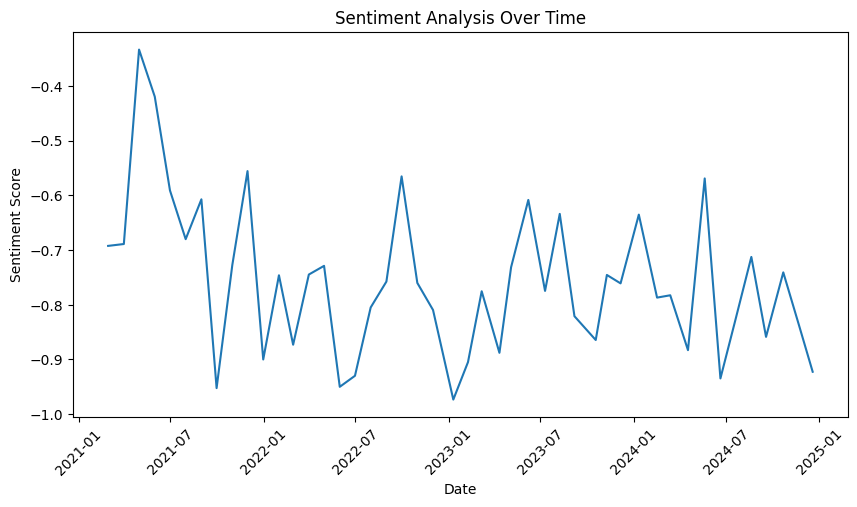

In [36]:
dates = [datetime.strptime(letter["date"], "%Y-%m-%d") for letter in letters]
sentiments = [letter["sentiment_balance"] for letter in letters]

plt.figure(figsize=(10, 5))
plt.plot(dates, sentiments)
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Over Time")
plt.xticks(rotation=45)
plt.show()